In [1]:
from qutip import tensor,qeye,destroy,sigmaz,sigmax,sigmay,mesolve,basis,heom
import numpy as np
import matplotlib.pyplot as plt
from qutip.solver.heom import BathExponent

class pseudomode:
    def __init__(self,Hsys,Q,bath):
        self.Hsys=Hsys
        self.Q=Q
        self.bath=bath
        self.coefficients()
    def coefficients(self):
        cks=np.zeros(len(self.bath.exponents)//2,dtype=np.complex128)
        vks=np.zeros(len(self.bath.exponents)//2,dtype=np.complex128)
        seen=set()
        i=0
        for exp in self.bath.exponents:
            if exp.vk not in seen:
                if exp.type ==BathExponent.types["R"]:
                    cks[i]=2*exp.ck 
                else:
                    cks[i]=2j*exp.ck
                vks[i]=-exp.vk
                seen.add(exp.vk.conjugate())
                i=i+1
        self.cks=cks
        self.vks=vks
    def tensor_id(self,pos,cutoff=2,op=None):
        temp=[qeye(cutoff)]*(len(self.cks)+1)
        if pos!=0:
            temp[0]=qeye(self.Hsys.shape[0])
            temp[pos]=destroy(cutoff)
        else:
            temp[0]=op
        return tensor(temp)
    def hamiltonian(self,cutoff=2):
        Hsys=self.tensor_id(0,cutoff,self.Hsys)
        Q=self.tensor_id(0,cutoff,self.Q)
        destroys=[self.tensor_id(i+1,cutoff) for i in range(len(self.cks))]
        for i in destroys:
            i.dims=Hsys.dims
        Hpm=sum([np.sqrt(-np.imag(i))*destroys[k].dag()*destroys[k] for k,i in enumerate(self.vks) ])
        Hsys_pm=sum([i*(destroys[k].dag()+destroys[k])*Q for k,i in enumerate(self.cks) ])
        Heff=Hsys+Hsys_pm+Hpm
        return Heff,destroys
    def power_spectrum(self,w):
        S=0
        for i in range(len(self.cks)):
            S += 2 * np.real(self.cks[i] / (self.vks[i] - 1j*w))
        return S
    def prepare(self,cutoff,initial):
        init=[initial]+[basis(cutoff,0)]*(len(self.cks))
        psi02 = tensor(init)
        psi02=psi02*psi02.dag()
        return psi02.to("CSR")
    
    def evolution(self,initial,cutoff,t,e_ops=[]):
        Heff,d=self.hamiltonian(cutoff)
        initial=self.prepare(cutoff,initial)
        e_ops=[self.tensor_id(0,cutoff,i) for i in e_ops]
        c_ops =sum([np.sqrt(-2*np.real(i)+0j)*d[k] for k,i in enumerate(self.vks) ])
        print(initial.dims)
        print(Heff.dims)
        print(c_ops.dims)
        return mesolve(Heff, initial, t, c_ops, e_ops)


In [2]:
N = 3
g=1
J=5*g
# initial state
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)

sx_list, sy_list, sz_list = [], [], []
for i in range(N):
    op_list = [qeye(2)] * N
    op_list[i] = sigmax()
    sx_list.append(tensor(op_list))
    op_list[i] = sigmay()
    sy_list.append(tensor(op_list))
    op_list[i] = sigmaz()
    sz_list.append(tensor(op_list))

# Hamiltonian - Energy splitting terms
H = 0
for i in range(N):
    H += g* sz_list[i]

for n in range(N - 1):
    H += -J* sx_list[n] * sx_list[n + 1]


In [3]:

E01=H.eigenenergies()[2]-H.eigenenergies()[0]# Raise this question about the paper 
gamma=3.8*g
w0=1.2*E01
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2 +0j)
lam=1.15*g*np.sqrt(Omega)

In [4]:
times = np.linspace(0, 10, 500)
bath=heom.UnderDampedBath(sz_list[-1],lam+0j,gamma+0j,w0,1e-18,5) # functions don't take zero because 1/T should be fixed
C=bath.correlation_function(times)

/home/mcditoos/qutip_gsoc_app/qutip/solver/heom/bofin_baths.py:425: RuntimeWarning: overflow encountered in exp
  return (1 / (np.exp(w / self.T) - 1))


In [5]:
cfiitter=heom.CorrelationFitter(sx_list[-1],0,times,C)
fbath,finfo=cfiitter.get_fit(Ni=1,Nr=2)
print(finfo['summary']) #notice one mode is also a pretty good approximation, maybe for this tiny examples r^{2}, might be better than RMSE

Fit correlation class instance: 
 
Result of fitting The Real Part Of                                      |Result of fitting The Imaginary Part                                    
 the Correlation Function with 2 terms:                                 | Of the Correlation Function with 1 terms:                              
                                                                        |                                                                        
 Parameters|    a     |    b     |    c                                 | Parameters|    a     |    b     |    c                                 
 1         | 6.69e-01 |-1.92e+00 |1.10e+01                              | 1         |-6.61e-01 |-1.90e+00 |1.10e+01                              
 2         |-7.61e-02 |-9.66e+00 |7.18e-09                              |                                                                        
                                                                        |A  normalized RM

In [6]:
lam**2/(2*Omega), Omega, Gamma, # Imaginary part is just the C0th component

((0.6612499999999999+0j), (10.983541778938223+0j), 1.9)

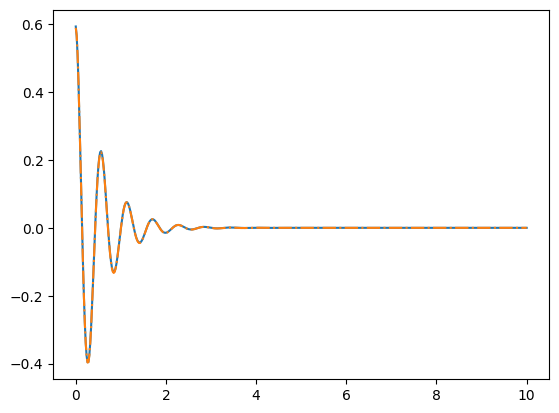

In [7]:
plt.plot(times,np.real(fbath.correlation_function_approx(times)))
plt.plot(times,np.real(C),'-.')

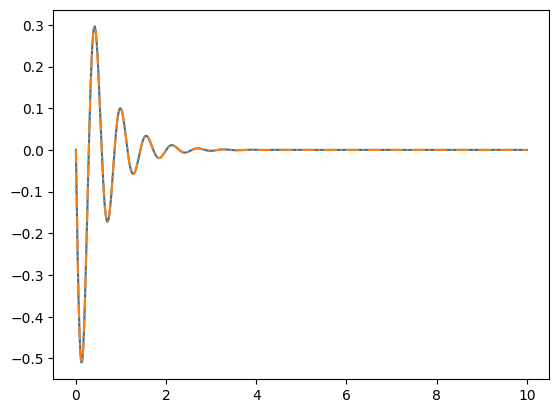

In [8]:
plt.plot(times,np.imag(fbath.correlation_function_approx(times)))
plt.plot(times,np.imag(C),'-.')

In [9]:
example=pseudomode(H,Q=sx_list[-1],bath=fbath)

In [10]:
state_list = [basis(2, 1)] + [basis(2, 0)] * (N - 1)
psi0 = tensor(state_list)
times=np.linspace(0,100,500)
evo=example.evolution(psi0,cutoff=2,t=times,e_ops=[H])

/tmp/ipykernel_568970/444035680.py:42: RuntimeWarning: invalid value encountered in sqrt
  Hpm=sum([np.sqrt(-np.imag(i))*destroys[k].dag()*destroys[k] for k,i in enumerate(self.vks) ])
/home/mcditoos/anaconda3/envs/qutip-jax/lib/python3.11/site-packages/scipy/integrate/_ode.py:1011: UserWarning: _zvode: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]]
[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]]
[[2, 2, 2, 2, 2, 2], [2, 2, 2, 2, 2, 2]]
 ZVODE--  At T (=R1) and step size H (=R2), the    
       corrector convergence failed repeatedly     
       or with abs(H) = HMIN   
      In above,  R1 =  0.0000000000000D+00   R2 =  0.2623853561067D-10


IntegratorException: Repeated convergence failures. (Perhaps bad Jacobian supplied or wrong choice of MF or tolerances.)

In [ ]:
evo.expect[0][-1]

-0.5354857859967562

In [ ]:
H.eigenenergies()

array([-10.28888935, -10.21207538,  -1.        ,  -0.92318603,
         0.92318603,   1.        ,  10.21207538,  10.28888935])